<a href="https://colab.research.google.com/github/Funatlearn/langgraph101/blob/main/Agents/4_DrafterAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ReAct Agent

Objectives:
1. Learn how to create Tools in LangGraph
2. How to create ReAct Graph
3. Work wiht different types of Messages such as ToolMessages
4. Test out robustness of our graph
Main Goal: Create a robust ReAct agent

In [31]:
# Fifth agent, to demonstrates conditional agent
# This is exercide, not completed
!pip install langgraph langchain_core langchain_openai langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.2 MB/s eta 0:00:00


In [32]:

from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage # Base - foundational class for all messages, Tool -> passes data back to LLM after it calls a tool, System -> provide instruction to LLM
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END # graph
from langgraph.prebuilt import ToolNode
from dotenv import load_dotenv
from langchain_groq import ChatGroq
import os
from google.colab import userdata



In [4]:
load_dotenv()

False

In [ ]:
# Reducer function
# Rule that controls how updates from nodes are combined with the existing state.
# Tell us how to merge data into new state

# Without reducer, updates would have replaced the existing value entirely!

In [47]:
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]


@tool
def add(a:int , b:int):
    """This is addition function to add 2 numbers"""
    return a+ b

@tool
def subtract(a: int, b: int):
    """Subtraction function"""
    return a - b

@tool
def multiply(a: int, b: int):
    """Multiplication function"""
    return a * b
tools = [add, subtract, multiply]

# sk-c5a2bcb9ddf7475d8498eb56a47a9e5a

#model = ChatOpenAI(model="gpt-4o", api_key = userdata.get('OPEN_API_KEY')  ).bind_tools(tools)
# Initialize DeepSeek model
# model = ChatOpenAI(
#     model="deepseek-chat",  # or "deepseek-coder" for coding tasks
#     api_key="sk-c5a2bcb9ddf7475d8498eb56a47a9e5a",  # Replace with your actual DeepSeek API key
#     base_url="https://api.deepseek.com/v1",  # DeepSeek API endpoint
#     temperature=0  # Optional: for more deterministic responses
# ).bind_tools(tools)

model = ChatGroq(
    model="llama-3.1-8b-instant",
    api_key=userdata.get('GROK_KEY')
).bind_tools(tools)


def model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are my AI assistant, please answer my query to the best of your ability."
    )
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"



In [48]:
graph = StateGraph(AgentState)

graph.add_node("our_agent", model_call)
graph.set_entry_point("our_agent")


tool_node = ToolNode(tools = tools)
graph.add_node("tools", tool_node)


graph.add_conditional_edges("our_agent",  should_continue, {
    "continue": "tools",
    "end": END
})

graph.add_edge("tools", "our_agent")


agent = graph.compile()

conversation_history = []

In [41]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

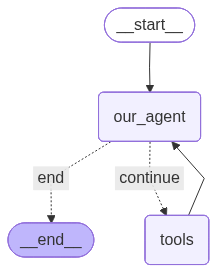

In [37]:
# display graph
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [49]:
inputs = {"messages": [("user","Add 40+12 and then multiply the result by 6. Also tell me a joke please")]}
print_stream(agent.stream(inputs, stream_mode="values"))
# inputs = {"messages": [("user", "Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.")]}
# print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40+12 and then multiply the result by 6. Also tell me a joke please
================================== Ai Message ==================================
Tool Calls:
  add (zggwjqesw)
 Call ID: zggwjqesw
  Args:
    a: 40
    b: 12
  multiply (0p8v46kny)
 Call ID: 0p8v46kny
  Args:
    a: 52
    b: 6
================================= Tool Message =================================
Name: multiply

312
================================== Ai Message ==================================

Here's a joke for you:

Why couldn't the bicycle stand up by itself?

Because it was two-tired!
